# Convolutional whitening

(Take 3)

Weights are shared across z's.
June 30, 2022

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Create a convolutional weight matrix

In [2]:
np.random.seed(1)

N = 5
x_dim = N
y_dim = N
z_dim = 2 * N - 1

W_hat = np.zeros((y_dim, z_dim))

for i in range(z_dim):
    if i < y_dim:
        W_hat[i, i] = 1
    else:
        W_hat[i - y_dim, i] = 1
        W_hat[i - y_dim + 1, i] = 1

## Simulate

In [5]:
# random Cxx
A = np.random.randn(N, N)
Cxx = A @ A.T

u, s, vh = np.linalg.svd(Cxx)

A = u @ np.diag(np.sqrt(s)) @ vh

T = 512  # batch size
n_batch = int(2**13)
norm_w_sq = np.diag(W_hat.T @ W_hat)
eta_g = 1e-3
g = np.ones(z_dim)  # init g
all_g = []
error = []

# run simulation
for _ in tqdm(range(n_batch)):
    x = A @ np.random.randn(x_dim, T)
    M = W_hat @ np.diag(g) @ W_hat.T
    M_inv = np.linalg.inv(M)
    y = M_inv @ x

    z = W_hat.T @ y

    dg = np.mean(z**2, axis=1) - norm_w_sq
    g = g + eta_g * dg
    all_g.append(g)
    error.append(np.linalg.norm(np.cov(y) - np.eye(N)) ** 2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:02<00:00, 2990.75it/s]


## Plot

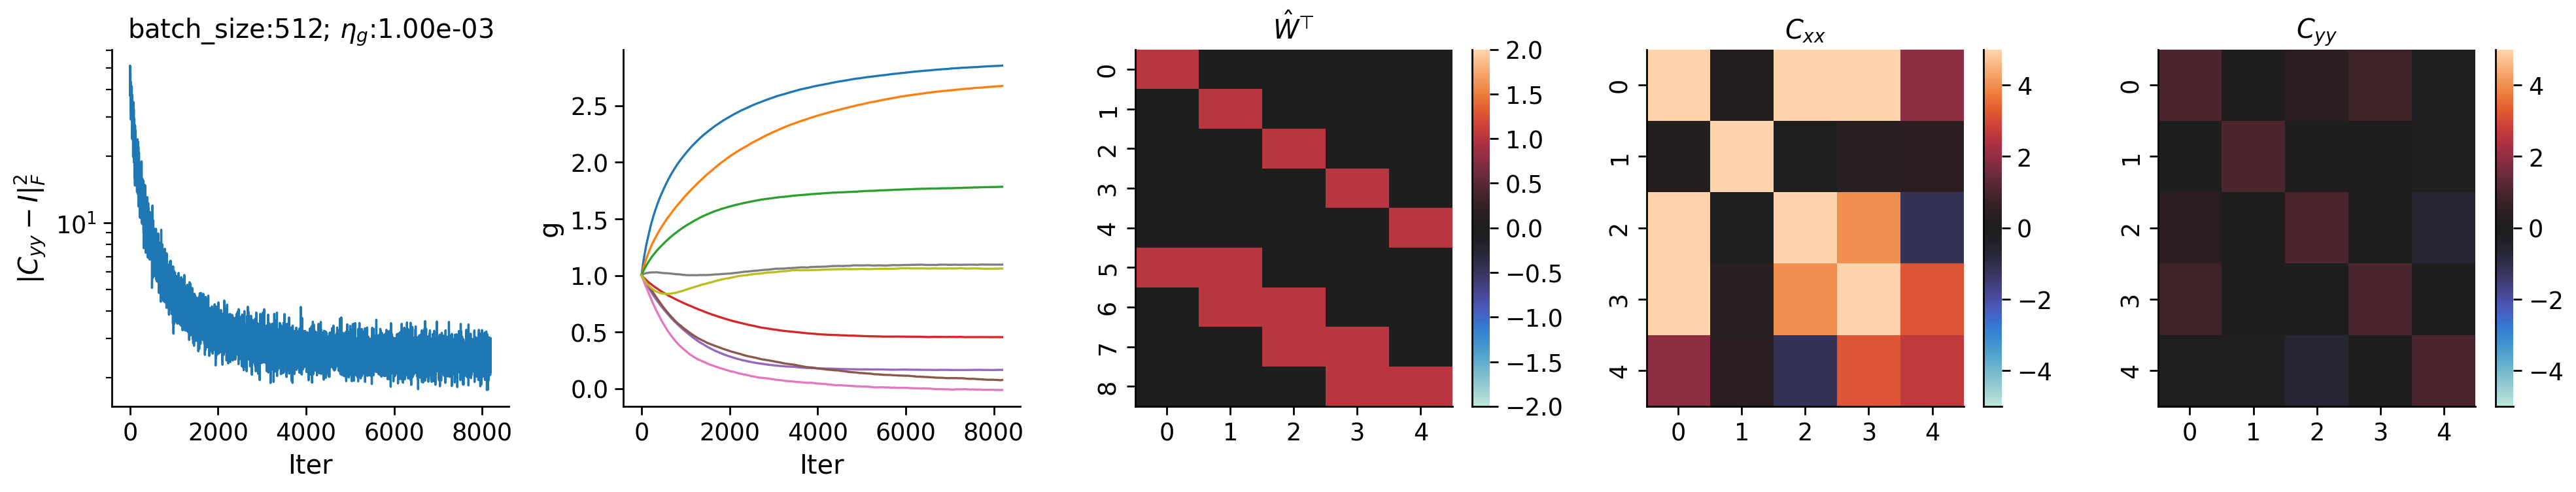

In [6]:
def heatmap(data, vlims, ax, cmap="icefire"):
    """Helper function to plot heatmaps"""
    sns.heatmap(data, cmap=cmap, vmin=vlims[0], vmax=vlims[1], ax=ax)

vlims = (-5, 5)

# compute M = (W G W.T)^-1 and Cyy
M_inv = np.linalg.inv(M)
Cyy = M_inv @ Cxx @ M_inv

with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4), dpi=200)
    ax[0].plot(error)
    ax[1].plot(all_g)
    heatmap(W_hat.T, (-2, 2), ax[2])
    heatmap(Cxx, vlims, ax[3])
    heatmap(Cyy, vlims, ax[4])

    ax[0].set(
        title=f"batch_size:{T}; $\eta_g$:{eta_g:.2e}",
        xlabel="Iter",
        ylabel=r"$\vert C_{yy}- I\vert^2_F$",
        yscale="log",
    )
    ax[1].set(title=f"", xlabel="Iter", ylabel="g")
    ax[2].set(title=r"$\hatW^\top$", xlabel="", ylabel="")
    ax[3].set(title=r"$C_{xx}$")
    ax[4].set(title=r"$C_{yy}$")
    sns.despine()
    fig.tight_layout()
